# **Fintech churn**

In [ ]:
# Importar e instalar dependencias

# Librerías para procesamiento de datos y algebra lineal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Descarga de archivos de drive
!pip install gdown

# Carga de datos

###Descarga del archivo

In [ ]:
import pandas as pd

# Descarga el archivo del dataset de drive usando gdown

# url = 'https://drive.google.com/file/d/1D_KAfe-xOVEdUml39xrWtPXZYXMNKD0H/view?usp=drive_link'  # dataset crudo
url = 'https://drive.google.com/file/d/1HNLHe6d8AW8vp0RBuzN4cWDzRjLx48Ae/view?usp=drive_link'    # dataset limpio
file_id = url.split('/')[-2]
!gdown --id $file_id

# Carga el dataset usando pandas
# sd = pd.read_csv('/content/Fintech_user.csv')  # dataset crudo
sd = pd.read_csv('/content/Fintech_user_limpio.csv')   # dataset limpio



/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1HNLHe6d8AW8vp0RBuzN4cWDzRjLx48Ae
To: /content/Fintech_user_limpio.csv
100% 2.26M/2.26M [00:00<00:00, 88.8MB/s]


In [ ]:
selected_features = [       "user",
                            "churn",
                            "purchases_partners",
                            "reward_rate",
                            "cc_recommended",
                            "web_user",
                            "received_loan",
                            "credit_score",
                            "age",
                            "deposits",
                            "withdrawal",
                            "is_referred",
                            "registered_phones",
                            "ios_user",
                            "waiting_4_loan",
                            "cancelled_loan",
                            "rejected_loan",
                            "left_for_two_month_plus",
                            "left_for_one_month"]

sd = sd[selected_features]

# Inspección inicial

In [ ]:
# Información general del dataset
sd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24741 entries, 0 to 24740
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user                     24741 non-null  int64  
 1   churn                    24741 non-null  int64  
 2   purchases_partners       24741 non-null  int64  
 3   reward_rate              24741 non-null  float64
 4   cc_recommended           24741 non-null  int64  
 5   web_user                 24741 non-null  int64  
 6   received_loan            24741 non-null  int64  
 7   credit_score             24741 non-null  float64
 8   age                      24741 non-null  int64  
 9   deposits                 24741 non-null  int64  
 10  withdrawal               24741 non-null  int64  
 11  is_referred              24741 non-null  int64  
 12  registered_phones        24741 non-null  int64  
 13  ios_user                 24741 non-null  int64  
 14  waiting_4_loan        

### Etapa de Machine Learning


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import joblib
import json


In [ ]:
correlation_matrix = sd.corr(numeric_only=True)

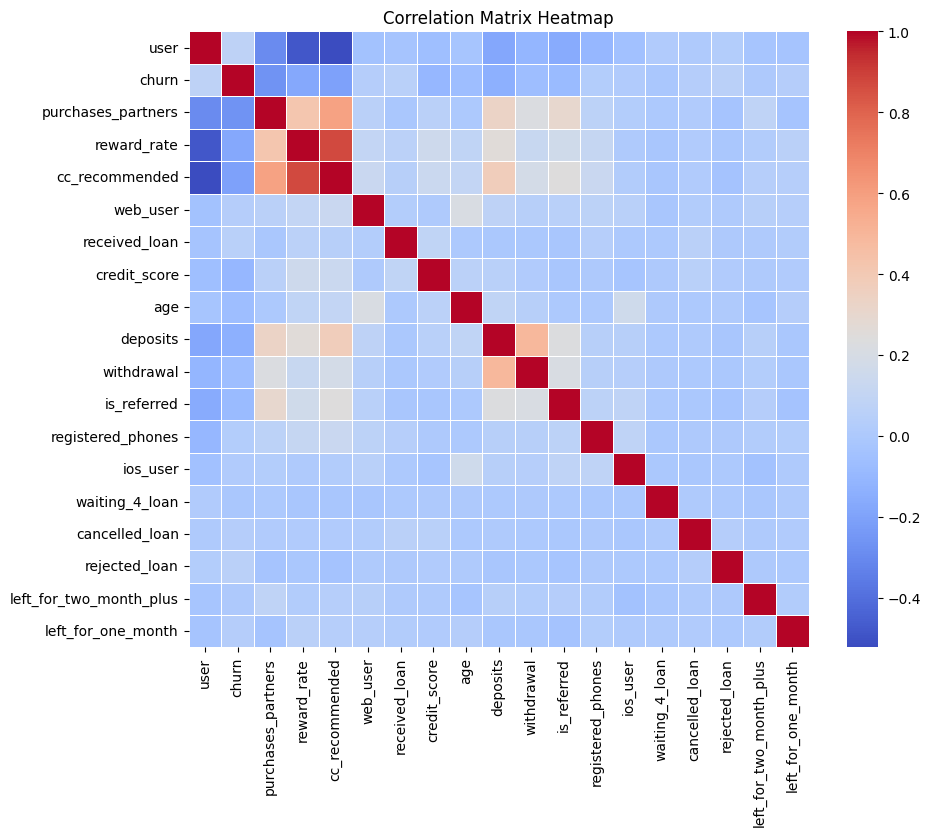

In [ ]:
plt.figure(figsize=(10, 8)) # Adjust figure size as needed
sns.heatmap(
        correlation_matrix,
        annot=False,      # True: Show correlation values on the heatmap
        cmap='coolwarm', # Choose a color map (e.g., 'coolwarm', 'viridis', 'RdYlGn')
        fmt=".2f",       # Format the annotations to two decimal places
        linewidths=.5    # Add lines between cells
    )
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
# balance de categorías del dataset
no_churn = 15368/(11174+15368)
churn = 11174/(11174+15368)
print(f"No churn:  {no_churn*100:.2f} %")
print(f"Churn: {churn*100:.2f} %")

No churn:  57.90 %
Churn: 42.10 %


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def load_and_preprocess_data(df):

    # # La columna user no es relevante
    if 'user' in df.columns:
       df = df.drop('user', axis=1)

    # Separar features y target
    X = df.drop('churn', axis=1)
    y = df['churn']

    # Normalizar con StandardScaler o MinMaxScaler
    scaler = MinMaxScaler().set_output(transform="pandas")
    # Seleccionar columnas a normalizar
    selected_cols= ["purchases_partners",
                    "reward_rate",
                    "cc_recommended",
                    "web_user",
                    "received_loan",
                    "credit_score",
                    "age",
                    "deposits",
                    "withdrawal",
                    "registered_phones" ]

    X[selected_cols] = scaler.fit_transform(X[selected_cols])
    # reversed_data = scaler.inverse_transform(scaled_data)
    return X, y ,scaler

### Preprocesamos escalando variables y guardamos 20% de los datos para validación


In [ ]:
X, y, scaler = load_and_preprocess_data(sd)

In [ ]:
X.head()

,purchases_partners,reward_rate,cc_recommended,web_user,received_loan,credit_score,age,deposits,withdrawal,is_referred,registered_phones,ios_user,waiting_4_loan,cancelled_loan,rejected_loan,left_for_two_month_plus,left_for_one_month
0,0.048735,0.4675,0.469349,1.0,0.0,0.513060,0.230769,0.738462,0.137931,0,0.4,0,0,0,0,0,0
1,0.068416,0.4075,0.381226,1.0,0.0,0.492537,0.384615,0.230769,0.000000,0,0.0,0,0,0,0,0,0
2,0.000000,0.1500,0.093870,0.0,0.0,0.404851,0.340659,0.000000,0.000000,1,0.0,0,0,0,0,0,0
3,0.028116,0.1925,0.107280,1.0,0.0,0.441791,0.285714,0.000000,0.000000,0,0.4,0,0,0,0,0,0
4,0.071228,0.3750,0.318008,0.0,0.0,0.477612,0.362637,0.000000,0.000000,1,0.0,0,0,0,0,1,0


In [ ]:
# guardar algunos datos para la demo
def save_demo_data(X,y, identifier):
  X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y )
  X_val = X_val.reset_index(drop =True)
  y_val = y_val.reset_index(drop = True)
  X_val.to_csv(f'churn_data_unseen_{identifier}.csv', index=False)
  y_val.to_csv(f'labels_churn_data_unseen_{identifier}.csv', index=False)
  X = X.reset_index(drop =True)
  y = y.reset_index(drop = True)
  # La columna user no es relevante para el entrenamiento del modelo
  if 'user' in X.columns:
    X = X.drop('user', axis=1)
  return X, y




In [ ]:
X, y = save_demo_data(X,y,identifier = "Selected_Features")

In [ ]:
X.shape

(19792, 17)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

In [ ]:
def plot_confusion_matrix(cm, classes=None, title='matriz de confusión'):
  plt.figure(figsize=(8,6))
  sns.heatmap(cm, xticklabels=classes, yticklabels=classes, annot=True, fmt='.2f', cmap=plt.cm.Blues)
  plt.title(title)
  plt.ylabel("verdadero")
  plt.xlabel("predicho")
  plt.show()


In [ ]:
def train_xgboost_model():
    """Train XGBoost classifier"""
    # Create XGBoost classifier
    model = xgb.XGBClassifier( )
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(f"Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    feature_importances = pd.DataFrame({"Feature": X_train.columns, "Importance": model.feature_importances_})
    feature_importances = feature_importances.sort_values(by="Importance", ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importances)
    plt.title("Feature Importance")
    plt.show()

    cm = confusion_matrix(y_test,y_pred)
    plot_confusion_matrix(cm, classes = ["no churn","churn"])



    return model, X_train.columns.tolist(),feature_importances


In [ ]:
def train_RF_model():
    """Train Random Forest classifier"""
    # Create XGBoost classifier
    rf_classifier = RandomForestClassifier(n_estimators = 10, random_state = 42)
    rf_classifier.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_classifier.predict(X_test)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(f"Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    feature_importances = pd.DataFrame({"Feature": X_train.columns, "Importance": rf_classifier.feature_importances_})
    feature_importances = feature_importances.sort_values(by="Importance", ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importances)
    plt.title("Feature Importance")
    plt.show()

    cm = confusion_matrix(y_test,y_pred)
    plot_confusion_matrix(cm, classes = ["no churn","churn"])



    return rf_classifier, X_train.columns.tolist(),feature_importances


Model Performance:
Accuracy: 0.6946
AUC Score: 0.7544

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      2171
           1       0.67      0.63      0.65      1788

    accuracy                           0.69      3959
   macro avg       0.69      0.69      0.69      3959
weighted avg       0.69      0.69      0.69      3959



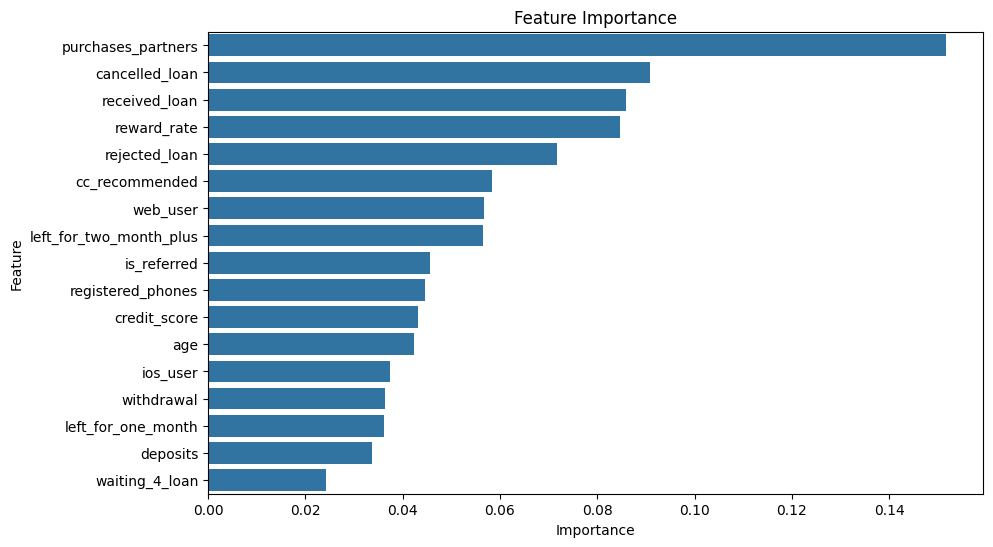

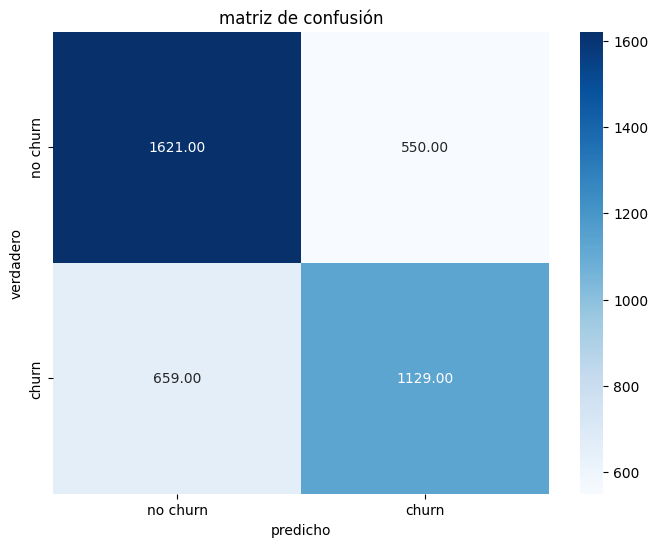

In [ ]:
XGBmodel, XGBcolumns, XGBfeature_importances = train_xgboost_model()

Model Performance:
Accuracy: 0.6643
AUC Score: 0.7249

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.78      0.72      2171
           1       0.66      0.53      0.59      1788

    accuracy                           0.66      3959
   macro avg       0.66      0.65      0.65      3959
weighted avg       0.66      0.66      0.66      3959



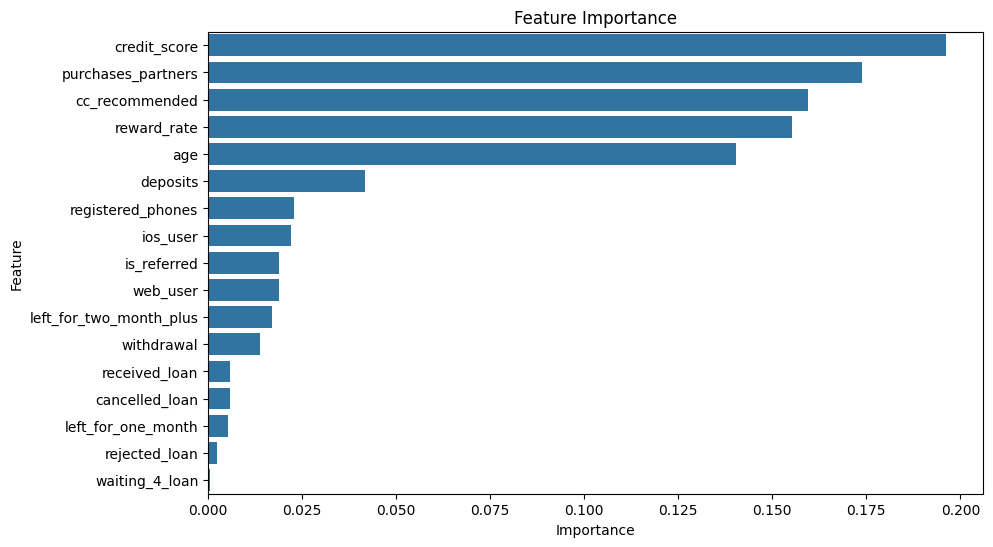

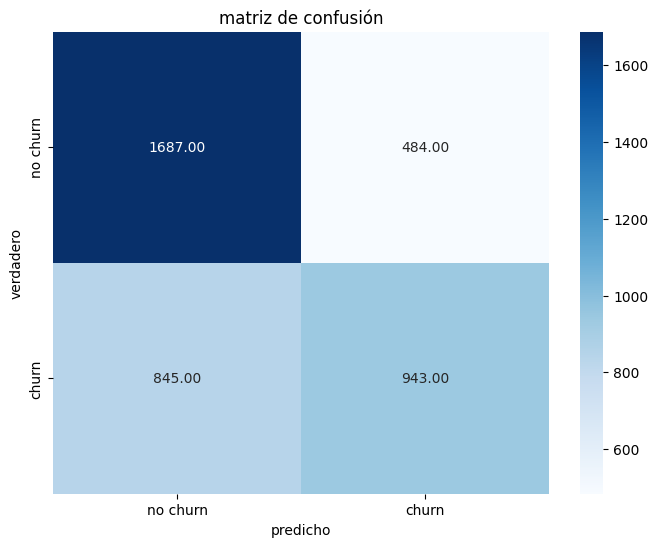

In [ ]:
RFmodel, RFcolumns, RFfeature_importances = train_RF_model()

In [ ]:
X.shape, X_test.shape, X_train.shape, y.shape,y_train.shape, y_test.shape

((19792, 17), (3959, 17), (15833, 17), (19792,), (15833,), (3959,))

In [ ]:
y_pred_prob_all_XGB = XGBmodel.predict_proba(X)
y_pred_prob_train_XGB = XGBmodel.predict_proba(X_train)
y_pred_prob_test_XGB = XGBmodel.predict_proba(X_test)

y_pred_prob_all_RF = RFmodel.predict_proba(X)
y_pred_prob_train_RF = RFmodel.predict_proba(X_train)
y_pred_prob_test_RF = RFmodel.predict_proba(X_test)

In [ ]:
y_pred_prob_all_XGB.shape, y.shape

((19792, 2), (19792,))

In [ ]:
y_pred_prob_all_XGB[:,0]

array([0.20686412, 0.36924314, 0.30787325, ..., 0.7419588 , 0.6750784 ,
       0.07861185], dtype=float32)

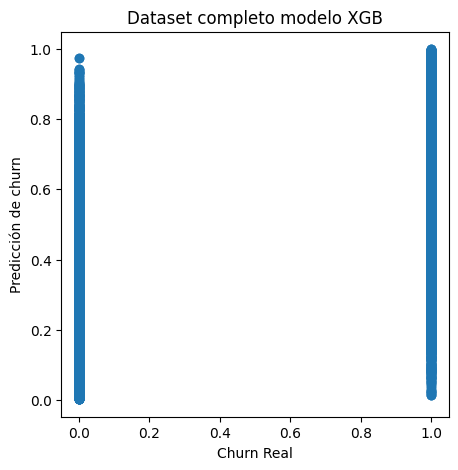

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred_prob_all_XGB[:,1])
# plt.plot([0,1],[0,1], color='r', linestyle='-', linewidth=2)
plt.xlabel('Churn Real')
plt.ylabel('Predicción de churn')
plt.title('Dataset completo modelo XGB')
plt.show()

In [ ]:
y_pred_prob_all_XGB[:,1].shape

(19792,)

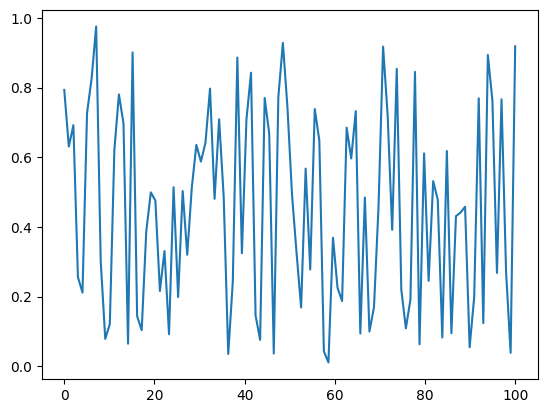

In [ ]:
x0 = np.linspace(0,len(y_pred_prob_all_XGB[0:100,1]),len(y_pred_prob_all_XGB[0:100,1]))
plt.plot(x0, y_pred_prob_all_XGB[0:100,1])
plt.show()


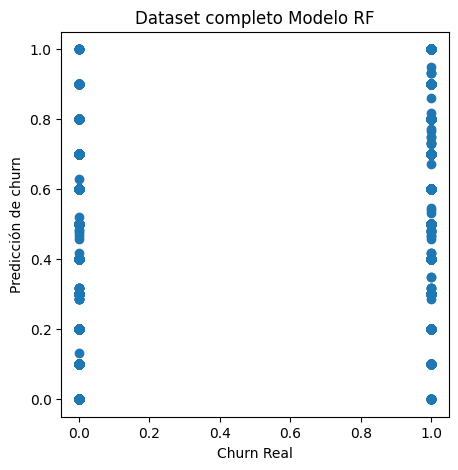

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred_prob_all_RF[:,1])
# plt.plot([0,1],[0,1], color='r', linestyle='-', linewidth=2)
plt.xlabel('Churn Real')
plt.ylabel('Predicción de churn')
plt.title('Dataset completo Modelo RF')
plt.show()

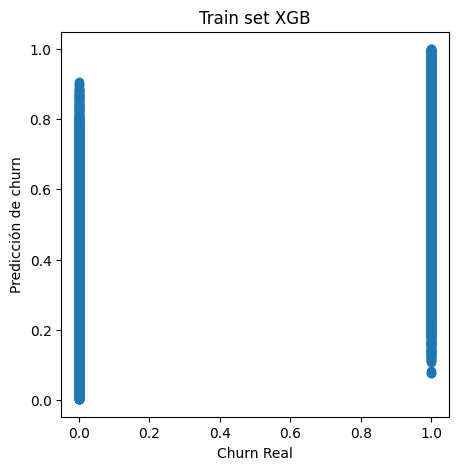

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(y_train, y_pred_prob_train_XGB[:,1])
# plt.plot([0,1],[0,1], color='r', linestyle='-', linewidth=2)
plt.xlabel('Churn Real')
plt.ylabel('Predicción de churn')
plt.title('Train set XGB')
plt.show()

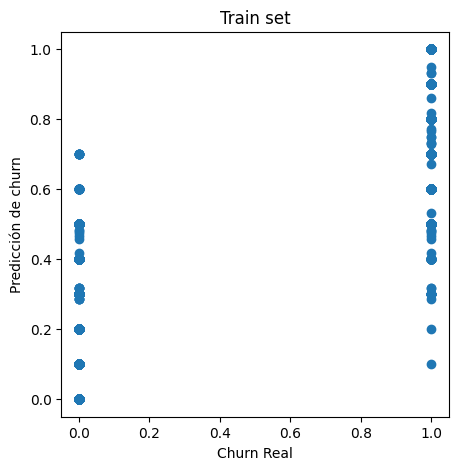

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(y_train, y_pred_prob_train_RF[:,1])
# plt.plot([0,1],[0,1], color='r', linestyle='-', linewidth=2)
plt.xlabel('Churn Real')
plt.ylabel('Predicción de churn')
plt.title('Train set')
plt.show()

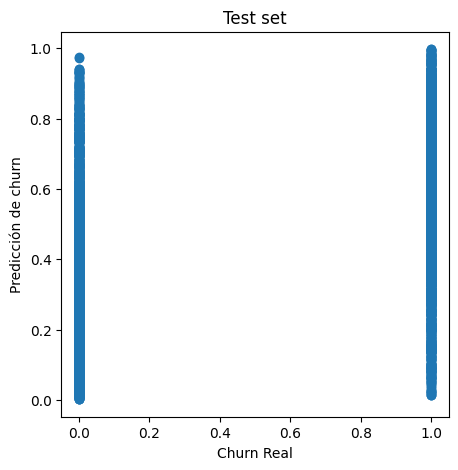

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred_prob_test_XGB[:,1])
# plt.plot([0,1],[0,1], color='r', linestyle='-', linewidth=2)
plt.xlabel('Churn Real')
plt.ylabel('Predicción de churn')
plt.title('Test set')
plt.show()

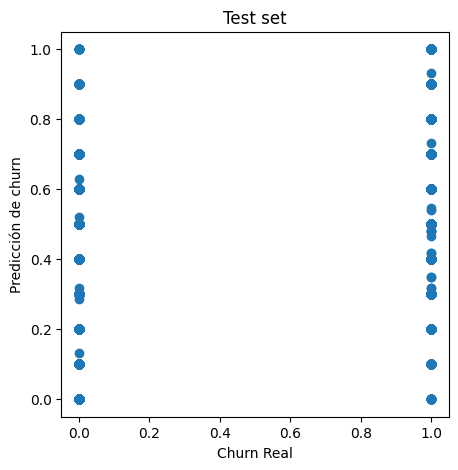

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred_prob_test_RF[:,1])
# plt.plot([0,1],[0,1], color='r', linestyle='-', linewidth=2)
plt.xlabel('Churn Real')
plt.ylabel('Predicción de churn')
plt.title('Test set')
plt.show()

## SHAP

In [ ]:
import shap


In [ ]:
shap.initjs()

In [ ]:
explainerXGB = shap.TreeExplainer(XGBmodel,X_train)


In [ ]:
explainerRF = shap.TreeExplainer(RFmodel,X_train)

In [ ]:
shap_values_XGB = explainerXGB.shap_values(X_test, check_additivity=False)

 99%|===================| 3907/3959 [00:33<00:00]       

In [ ]:
shap_values_XGB.shape

(3959, 17)

In [ ]:
shap_values_RF = explainerRF.shap_values(X_test, check_additivity=False)
# este cálculo tarda mucho más que el de XGBoost

 99%|===================| 7821/7918 [01:15<00:00]       

In [ ]:
N_cliente = 3550
print(XGBmodel.predict(X_test.iloc[N_cliente:N_cliente+1]))
shap.Explanation(values = shap_values_XGB[N_cliente,1],base_values = explainerXGB.expected_value,
                 data = X_test.iloc[N_cliente],feature_names=X_test.columns.tolist()),

[1]


(.values =
 np.float64(0.39974837422429116)
 
 .base_values =
 np.float64(-0.27874609924944255)
 
 .data =
 purchases_partners         0.000000
 reward_rate                0.025000
 cc_recommended             0.000000
 web_user                   0.000000
 received_loan              0.000000
 credit_score               0.302239
 age                        0.230769
 deposits                   0.000000
 withdrawal                 0.000000
 is_referred                0.000000
 registered_phones          0.000000
 ios_user                   0.000000
 waiting_4_loan             0.000000
 cancelled_loan             0.000000
 rejected_loan              0.000000
 left_for_two_month_plus    0.000000
 left_for_one_month         0.000000
 Name: 17106, dtype: float64,)

In [ ]:
test_customer = {
    "purchases_partners": 90,
    "reward_rate": 5.0,
    "cc_recommended": 80,
    "web_user": 1,
    "received_loan": 1,
    "credit_score": 800.0,
    "age": 65,
    "deposits": 100,
    "withdrawal": 10,
    "is_referred": 1,
    "registered_phones": 1,
    "ios_user": 1,
    "waiting_4_loan": 0,
    "cancelled_loan": 0,
    "rejected_loan": 0,
    "left_for_two_month_plus": 0,
    "left_for_one_month": 0,
}


In [ ]:
unseen_data = pd.DataFrame(test_customer, index=[0])

NameError: name 'pd' is not defined

In [ ]:
unseen_data.shape

(1, 17)

In [ ]:
XGBmodel.predict(unseen_data)

array([1])

In [ ]:
RFmodel.predict(unseen_data)

array([1])

In [ ]:
XGBmodel.predict_proba(unseen_data)

array([[0.35153884, 0.64846116]], dtype=float32)

In [ ]:
RFmodel.predict_proba(unseen_data)

array([[0.4, 0.6]])

In [ ]:
explainerRF.shap_values(unseen_data)[0][:,1]


array([-0.04055734,  0.00623938,  0.05588855,  0.00771081,  0.02003153,
       -0.02467299, -0.01164839,  0.04521255, -0.00632955,  0.02028406,
        0.08802906, -0.00658299,  0.        , -0.00129683, -0.00137493,
       -0.00340954, -0.00010675])

In [ ]:
explainerXGB.expected_value

np.float64(-0.27874609924944255)

In [ ]:
shap.Explanation(       values = explainerXGB.shap_values(unseen_data)[0],
                        base_values = explainerXGB.expected_value,
                        data = unseen_data,
                        feature_names=X_test.columns.tolist())

.values =
array([-0.81449129, -0.12172531,  1.03884598,  0.05063115, -0.28641076,
       -0.30083034,  0.08440228,  0.1927807 ,  0.5032772 ,  0.15849509,
        0.16141795,  0.27223037,  0.        , -0.01652186, -0.01157935,
       -0.02207981,  0.00258627])

.base_values =
np.float64(-0.27874609924944255)

.data =
   purchases_partners  reward_rate  cc_recommended  web_user  received_loan  \
0                   9          0.0               0         1              1   

   credit_score  age  deposits  withdrawal  is_referred  registered_phones  \
0         300.0   65         1           1            1                  1   

   ios_user  waiting_4_loan  cancelled_loan  rejected_loan  \
0         1               0               0              0   

   left_for_two_month_plus  left_for_one_month  
0                        0                   0  

In [ ]:
shap.Explanation(       values = explainerRF.shap_values(unseen_data)[0],
                        base_values = explainerRF.expected_value,
                        data = unseen_data,
                        feature_names=X_test.columns.tolist())

.values =
array([[ 0.04055734, -0.04055734],
       [-0.00623938,  0.00623938],
       [-0.05588856,  0.05588855],
       [-0.00771081,  0.00771081],
       [-0.02003153,  0.02003153],
       [ 0.02467299, -0.02467299],
       [ 0.01164839, -0.01164839],
       [-0.04521256,  0.04521255],
       [ 0.00632954, -0.00632955],
       [-0.02028406,  0.02028406],
       [-0.08802907,  0.08802906],
       [ 0.00658299, -0.00658299],
       [ 0.        ,  0.        ],
       [ 0.00129683, -0.00129683],
       [ 0.00137493, -0.00137493],
       [ 0.00340954, -0.00340954],
       [ 0.00010675, -0.00010675]])

.base_values =
array([0.54741667, 0.45258333])

.data =
   purchases_partners  reward_rate  cc_recommended  web_user  received_loan  \
0                   9          0.0               0         1              1   

   credit_score  age  deposits  withdrawal  is_referred  registered_phones  \
0         300.0   65         1           1            1                  1   

   ios_user  waiting_

In [ ]:
explainerXGB.shap_values(unseen_data)

array([[-0.81449129, -0.12172531,  1.03884598,  0.05063115, -0.28641076,
        -0.30083034,  0.08440228,  0.1927807 ,  0.5032772 ,  0.15849509,
         0.16141795,  0.27223037,  0.        , -0.01652186, -0.01157935,
        -0.02207981,  0.00258627]])

In [ ]:
explainerRF.shap_values(unseen_data)[:,:,1]

array([[-0.04055734,  0.00623938,  0.05588855,  0.00771081,  0.02003153,
        -0.02467299, -0.01164839,  0.04521255, -0.00632955,  0.02028406,
         0.08802906, -0.00658299,  0.        , -0.00129683, -0.00137493,
        -0.00340954, -0.00010675]])

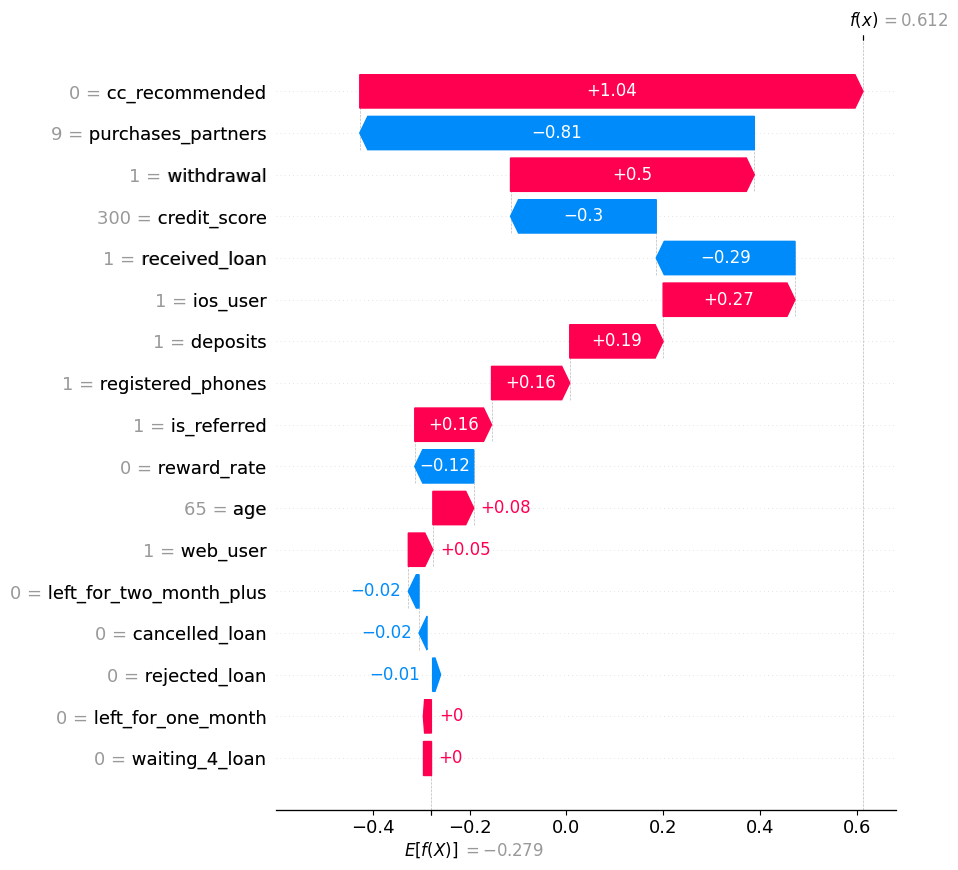

In [ ]:
shap.waterfall_plot(shap.Explanation(
                        values = explainerXGB.shap_values(unseen_data)[[0]],
                        base_values = explainerXGB.expected_value,
                        data = unseen_data,
                        feature_names=X_test.columns.tolist())[0],
                    max_display=17,
                    show=True
                    )

In [ ]:
explainerRF.shap_values(unseen_data)[:,:,1][0]

array([-0.04055734,  0.00623938,  0.05588855,  0.00771081,  0.02003153,
       -0.02467299, -0.01164839,  0.04521255, -0.00632955,  0.02028406,
        0.08802906, -0.00658299,  0.        , -0.00129683, -0.00137493,
       -0.00340954, -0.00010675])

In [ ]:
 explainerXGB.shap_values(unseen_data)[0]

array([-0.81449129, -0.12172531,  1.03884598,  0.05063115, -0.28641076,
       -0.30083034,  0.08440228,  0.1927807 ,  0.5032772 ,  0.15849509,
        0.16141795,  0.27223037,  0.        , -0.01652186, -0.01157935,
       -0.02207981,  0.00258627])

In [ ]:
shap.Explanation(
                        values = explainerRF.shap_values(unseen_data)[:,:,1][0],
                        base_values = explainerRF.expected_value[1],
                        data = unseen_data,
                        feature_names=X_test.columns.tolist())[0]

.values =
np.float64(-0.04055733975052135)

.base_values =
np.float64(0.45258333333333317)

.data =
purchases_partners           9.0
reward_rate                  0.0
cc_recommended               0.0
web_user                     1.0
received_loan                1.0
credit_score               300.0
age                         65.0
deposits                     1.0
withdrawal                   1.0
is_referred                  1.0
registered_phones            1.0
ios_user                     1.0
waiting_4_loan               0.0
cancelled_loan               0.0
rejected_loan                0.0
left_for_two_month_plus      0.0
left_for_one_month           0.0
Name: 0, dtype: float64

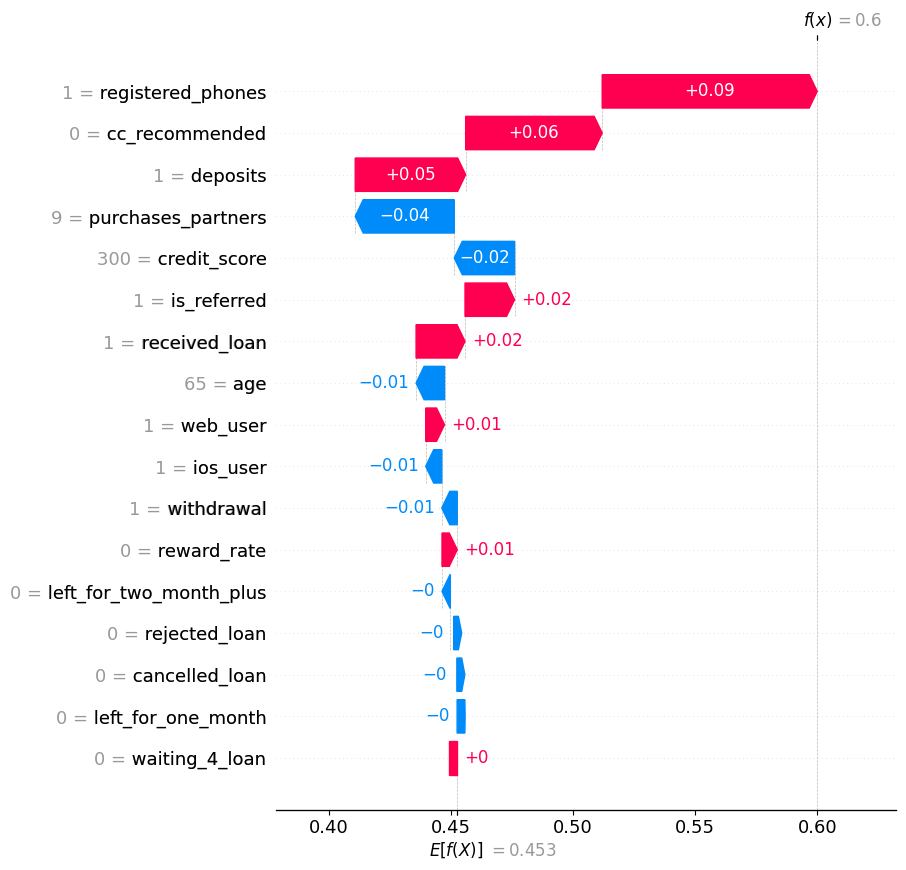

In [ ]:
shap.waterfall_plot(shap.Explanation(
                        values = explainerRF.shap_values(unseen_data)[:,:,1],
                        base_values = explainerRF.expected_value[1],
                        data = unseen_data,
                        feature_names=X_test.columns.tolist())[0],
                    max_display=17,
                    show=True
                    )



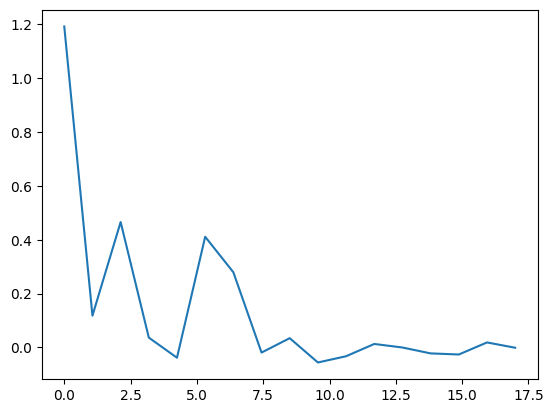

In [ ]:
plt.figure()
x0 = np.linspace(0,len(shap_values_XGB[0]),len(shap_values_XGB[0]))
plt.plot(x0,shap_values_XGB[0])
plt.show()


In [ ]:
 def sigmoid(x):
  """
  Calculates the sigmoid function for a given input x.

  Args:
    x: A numerical value or a NumPy array.

  Returns:
    The sigmoid value(s) corresponding to the input x.
  """
  return 1 / (1 + np.exp(-x))

In [ ]:
shap_values_XGB_sigmoid = sigmoid(shap_values_XGB)
shap_values_RF_sigmoid = sigmoid(shap_values_RF)

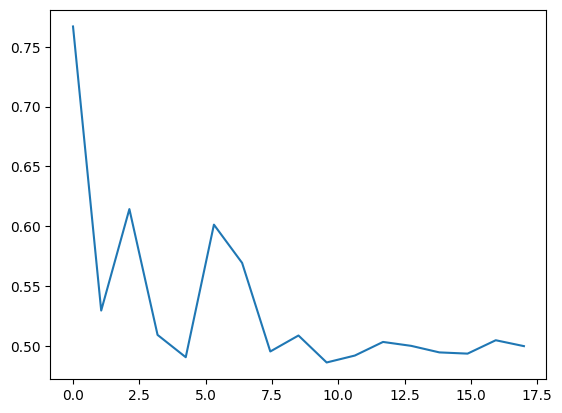

In [ ]:
plt.figure()
x0 = np.linspace(0,len(shap_values_XGB_sigmoid[0]),len(shap_values_XGB_sigmoid[0]))
plt.plot(x0,shap_values_XGB_sigmoid[0])
plt.show()

In [ ]:
shap_values_RF[:,:,0].shape, shap_values_XGB.shape

((3959, 17), (3959, 17))

/tmp/ipython-input-3423913630.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_XGB,X_test, show=False)
/tmp/ipython-input-3423913630.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_RF[:,:,1],X_test, show=False)


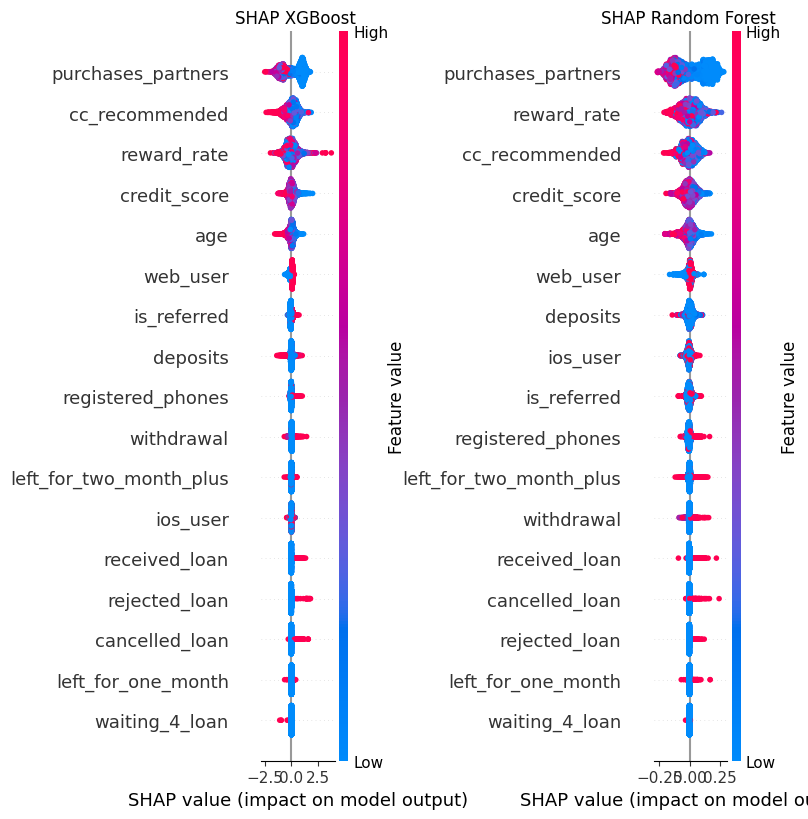

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 12), sharey=False)

plt.sca(axes[0]) # Set the current axes to the first subplot
shap.summary_plot(shap_values_XGB,X_test, show=False)
axes[0].set_title('SHAP XGBoost ')

plt.sca(axes[1]) # Set the current axes to the second subplot
shap.summary_plot(shap_values_RF[:,:,1],X_test, show=False)
axes[1].set_title('SHAP Random Forest ')

# plt.tight_layout()
plt.show()


In [ ]:
shap_values_RF[0,:,1]

array([ 0.2309389 ,  0.02942004,  0.02175774, -0.01031151, -0.00314048,
        0.02868433,  0.04971528,  0.03071548, -0.00275397, -0.01761468,
       -0.00977262,  0.00111071,  0.        , -0.00184683, -0.00194762,
        0.00279524, -0.00033333])

In [ ]:
shap_values_XGB.shape

(3959, 17)

In [ ]:
shap_values_XGB[0,:]

array([ 1.19113115e+00,  1.18114385e-01,  4.65486525e-01,  3.66536304e-02,
       -3.79684422e-02,  4.10906734e-01,  2.79136848e-01, -1.87841964e-02,
        3.46153119e-02, -5.55794495e-02, -3.24252105e-02,  1.30939804e-02,
        0.00000000e+00, -2.18713852e-02, -2.59750370e-02,  1.87780464e-02,
       -9.27122794e-04])

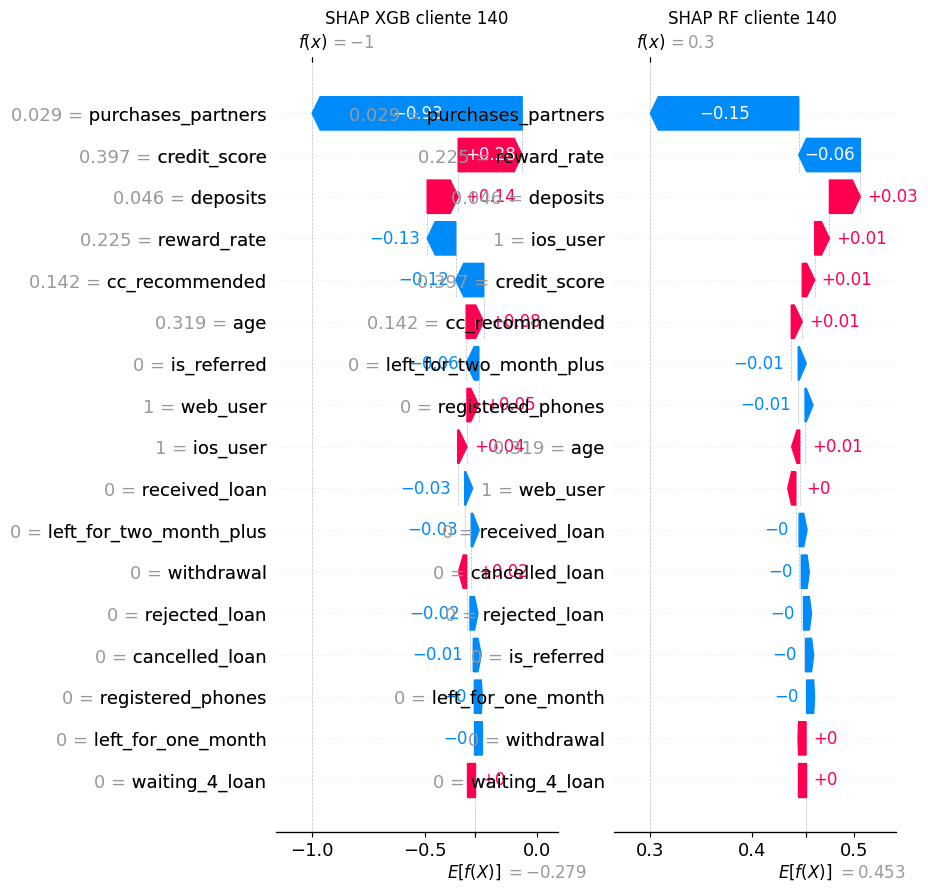

In [ ]:
# muestrear un cliente
N_cliente = 140

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plt.sca(axes[0]) # Set the current axes to the first subplot

shap.waterfall_plot(shap.Explanation(
                        values = shap_values_XGB[N_cliente],
                        base_values = explainerXGB.expected_value,
                        data = X_test.iloc[N_cliente],
                        feature_names=X_test.columns.tolist()),
                    max_display=17,
                    show=False
                    )

axes[0].set_title(f'SHAP XGB cliente {N_cliente}')

plt.sca(axes[1]) # Set the current axes to the second subplot

shap.waterfall_plot(shap.Explanation(
                        values = shap_values_RF[N_cliente,:,1],
                        base_values = explainerRF.expected_value[1],
                        data = X_test.iloc[N_cliente],
                        feature_names=X_test.columns.tolist()),
                    max_display=17,
                    show=False
                    )

axes[1].set_title(f'SHAP RF cliente {N_cliente} ')

# plt.tight_layout()
plt.show()




In [ ]:
explanationXGB = shap.Explanation(
                        values = shap_values_XGB,
                        base_values = explainerXGB.expected_value,
                        data = X_test,
                        feature_names=X_test.columns.tolist())

In [ ]:
explanationRF = shap.Explanation(
                        values = shap_values_RF[:,:,1],
                        base_values = explainerRF.expected_value,
                        data = X_test,
                        feature_names=X_test.columns.tolist())

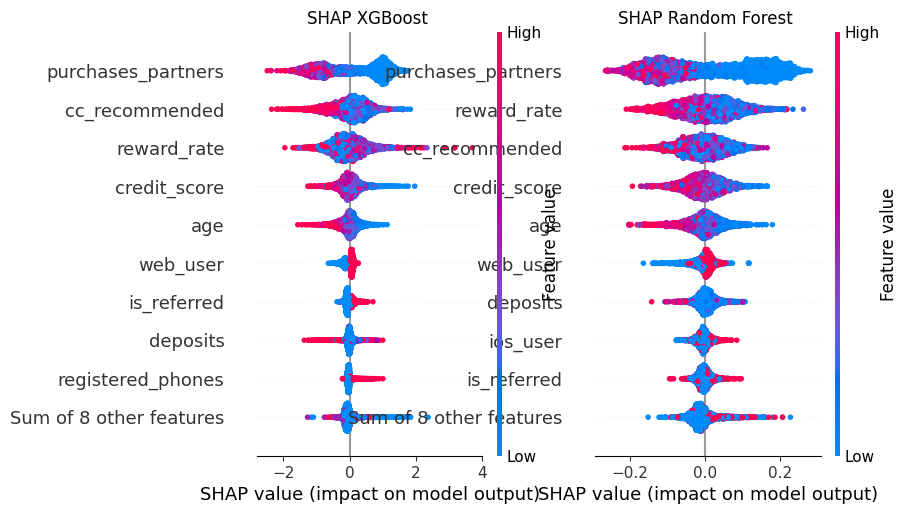

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 12), sharey=False)

plt.sca(axes[0]) # Set the current axes to the first subplot
shap.plots.beeswarm(explanationXGB, show=False)
axes[0].set_title('SHAP XGBoost ')

plt.sca(axes[1]) # Set the current axes to the second subplot
shap.plots.beeswarm(explanationRF, show= False)
axes[1].set_title('SHAP Random Forest ')

# plt.tight_layout()
plt.show()

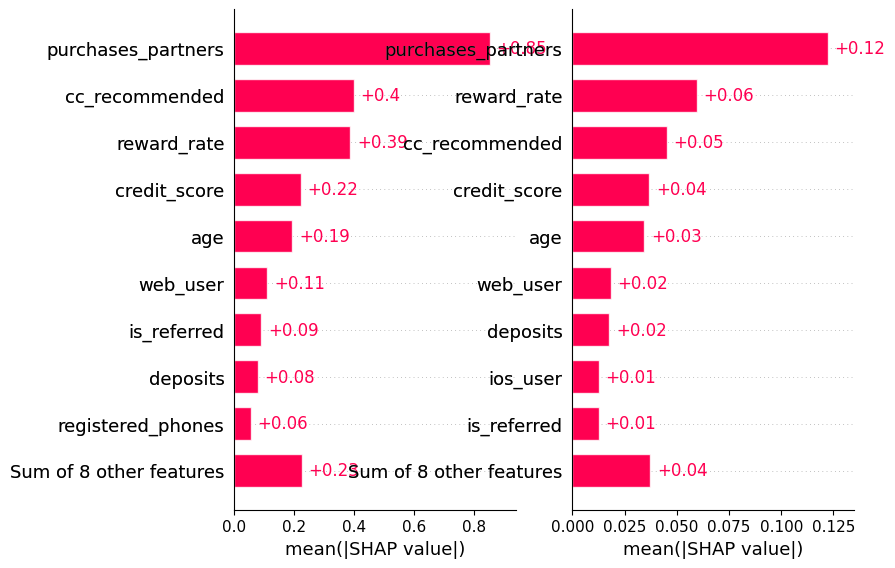

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12, 12))
plt.sca(axes[0])
shap.plots.bar(explanationXGB,show=False)
plt.sca(axes[1])
shap.plots.bar(explanationRF,show=False)
plt.show()

In [ ]:
explanationXGB.feature_names

['purchases_partners',
 'reward_rate',
 'cc_recommended',
 'web_user',
 'received_loan',
 'credit_score',
 'age',
 'deposits',
 'withdrawal',
 'is_referred',
 'registered_phones',
 'ios_user',
 'waiting_4_loan',
 'cancelled_loan',
 'rejected_loan',
 'left_for_two_month_plus',
 'left_for_one_month']

## Scatter plot
Each dot is a single prediction (row) from the dataset.

The x-axis is the value of the feature (from the X matrix, stored in **explanationXGB.data**).

The y-axis is the SHAP value for that feature (stored in **explanationXGB.values**), which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction.

In [ ]:
explanationXGB.values

array([[ 1.19113115e+00,  1.18114385e-01,  4.65486525e-01, ...,
        -2.59750370e-02,  1.87780464e-02, -9.27122794e-04],
       [-8.48344477e-01,  3.09655567e-02, -4.81451666e-01, ...,
        -1.81189565e-02,  2.35091888e-02, -9.27122794e-04],
       [ 4.89436616e-01, -5.62978874e-01, -4.15316845e-01, ...,
        -4.32243311e-02, -4.75069661e-02,  3.33431009e-04],
       ...,
       [ 1.33560396e+00, -6.47886260e-01,  4.63196132e-01, ...,
        -3.60952530e-02, -1.81184080e-02, -7.39655551e-04],
       [ 7.33974547e-01, -7.34510528e-01,  9.24439715e-01, ...,
        -3.85030743e-02, -2.20232956e-02,  2.01776414e-03],
       [-1.09234677e+00,  6.97598121e-01,  2.10816574e-01, ...,
        -2.97447707e-02, -2.57746360e-02, -9.27122794e-04]])

In [ ]:
scaler.data_max_

array([1.067e+03, 4.000e+00, 5.220e+02, 1.000e+00, 1.000e+00, 8.380e+02,
       9.100e+01, 6.500e+01, 2.900e+01, 5.000e+00])

In [ ]:
scaler.feature_names_in_

array(['purchases_partners', 'reward_rate', 'cc_recommended', 'web_user',
       'received_loan', 'credit_score', 'age', 'deposits', 'withdrawal',
       'registered_phones'], dtype=object)

In [ ]:
explanationXGB.data[scaler.feature_names_in_]

,purchases_partners,reward_rate,cc_recommended,web_user,received_loan,credit_score,age,deposits,withdrawal,registered_phones
7734,0.000000,0.4575,0.300766,1.0,0.0,0.417910,0.285714,0.000000,0.000000,0.0
5142,0.057170,0.3825,0.304598,0.0,0.0,0.537313,0.219780,0.000000,0.000000,0.0
12975,0.000937,0.0075,0.000000,0.0,0.0,0.426119,0.252747,0.000000,0.000000,0.0
399,0.000937,0.0125,0.000000,1.0,0.0,0.458955,0.263736,0.000000,0.000000,0.0
6134,0.009372,0.2000,0.019157,0.0,0.0,0.401866,0.373626,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
17672,0.000000,0.0000,0.000000,1.0,0.0,0.445896,0.340659,0.000000,0.000000,0.0
10318,0.039363,0.2325,0.195402,1.0,0.0,0.263060,0.329670,0.953846,0.068966,0.0
10131,0.000000,0.0000,0.007663,0.0,0.0,0.380597,0.318681,0.000000,0.000000,0.0
6528,0.000000,0.0000,0.003831,1.0,0.0,0.667910,0.329670,0.000000,0.000000,0.0


In [ ]:
reversed_data = scaler.inverse_transform(explanationXGB.data[scaler.feature_names_in_])

In [ ]:
reversed_data = pd.DataFrame(reversed_data, columns=scaler.feature_names_in_)


In [ ]:
reversed_data

,purchases_partners,reward_rate,cc_recommended,web_user,received_loan,credit_score,age,deposits,withdrawal,registered_phones
0,0.0,1.83,157.0,1.0,0.0,526.0,26.0,0.0,0.0,0.0
1,61.0,1.53,159.0,0.0,0.0,590.0,20.0,0.0,0.0,0.0
2,1.0,0.03,0.0,0.0,0.0,530.4,23.0,0.0,0.0,0.0
3,1.0,0.05,0.0,1.0,0.0,548.0,24.0,0.0,0.0,0.0
4,10.0,0.80,10.0,0.0,0.0,517.4,34.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3954,0.0,0.00,0.0,1.0,0.0,541.0,31.0,0.0,0.0,0.0
3955,42.0,0.93,102.0,1.0,0.0,443.0,30.0,62.0,2.0,0.0
3956,0.0,0.00,4.0,0.0,0.0,506.0,29.0,0.0,0.0,0.0
3957,0.0,0.00,2.0,1.0,0.0,660.0,30.0,0.0,0.0,0.0


In [ ]:
explanationXGB[:, "age"]

.values =
array([ 0.27913685,  0.52158837, -0.0745012 , ...,  0.0344607 ,
       -0.08461278, -0.01270186])

.base_values =
np.float64(-0.27874609924944255)

.data =
7734     0.285714
5142     0.219780
12975    0.252747
399      0.263736
6134     0.373626
           ...   
17672    0.340659
10318    0.329670
10131    0.318681
6528     0.329670
9377     0.296703
Name: age, Length: 3959, dtype: float64

In [ ]:
explanationXGB[:, 'age'].values

array([ 0.27913685,  0.52158837, -0.0745012 , ...,  0.0344607 ,
       -0.08461278, -0.01270186])

In [ ]:
explanationXGB[:, 'age'].data

,age
7734,0.285714
5142,0.219780
12975,0.252747
399,0.263736
6134,0.373626
...,...
17672,0.340659
10318,0.329670
10131,0.318681
6528,0.329670


In [ ]:
explanationXGB.shape, explanationXGB[:,'age'].data.shape

((3959, 17), (3959,))

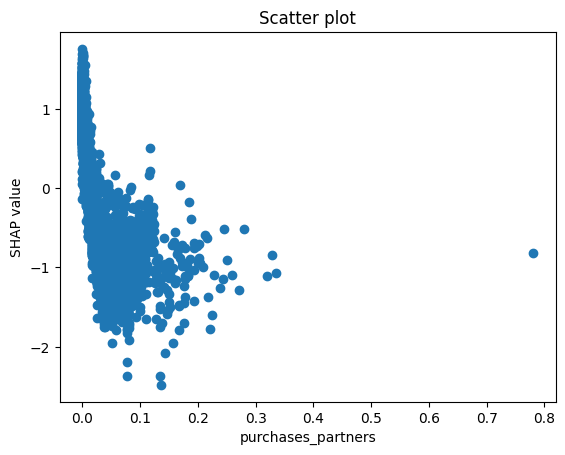

In [ ]:
c ='purchases_partners'
plt.figure()
plt.scatter(explanationXGB[:,c].data, explanationXGB[:,c].values)
plt.xlabel(c)
plt.ylabel('SHAP value')
plt.title('Scatter plot')
plt.show()


In [ ]:
shap_interaction_values = explainerXGB.shap_interaction_values(X_test)
shap_interaction_values[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

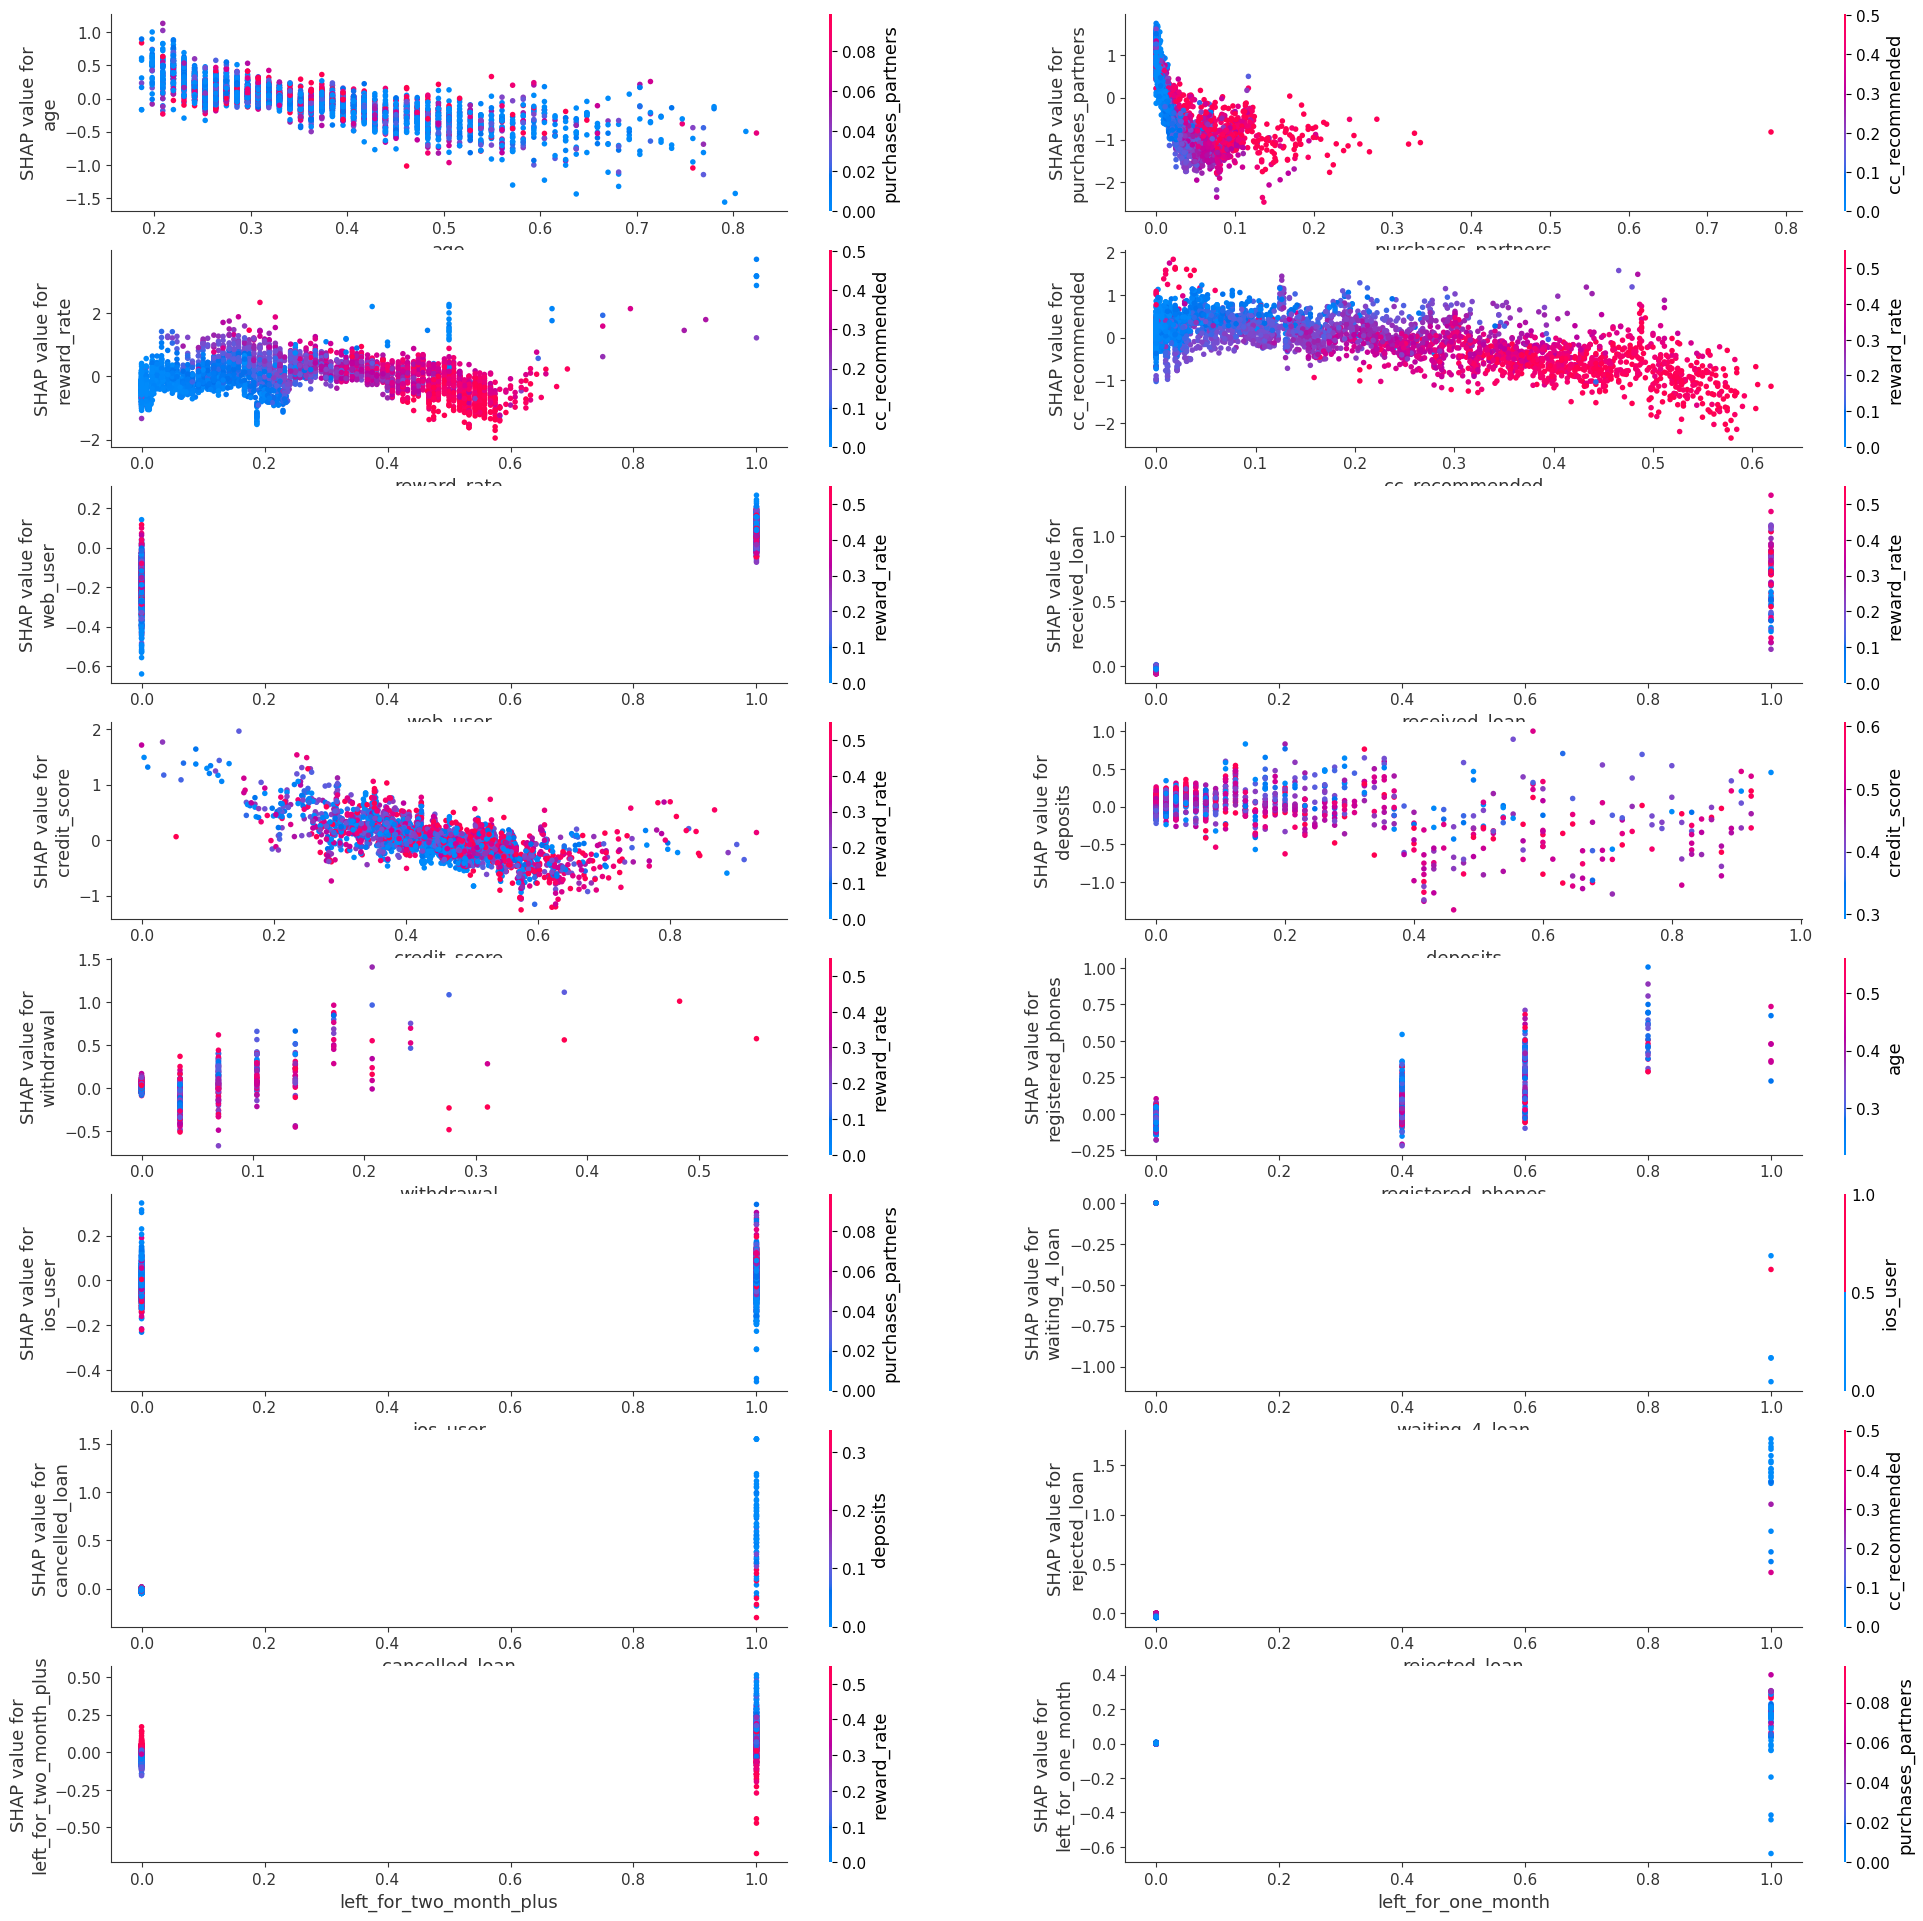

In [ ]:
fig, axe = plt.subplots(8,2,figsize=(24, 24))
axes = axe.ravel()
# plt.sca(axes[0])
shap.dependence_plot("age", shap_values_XGB, X_test, show= False, ax=axes[0])
# plt.sca(axes[1])
shap.dependence_plot("purchases_partners", shap_values_XGB, X_test, show= False, ax=axes[1])
# plt.sca(axes[2])
shap.dependence_plot("reward_rate", shap_values_XGB, X_test, show= False, ax=axes[2])
# plt.sca(axes[3])
shap.dependence_plot("cc_recommended", shap_values_XGB, X_test, show= False, ax=axes[3])
# plt.sca(axes[4])
shap.dependence_plot("web_user", shap_values_XGB, X_test, show= False, ax=axes[4])
# plt.sca(axes[5])
shap.dependence_plot("received_loan", shap_values_XGB, X_test, show= False, ax=axes[5])
# plt.sca(axes[6])
shap.dependence_plot("credit_score", shap_values_XGB, X_test, show= False, ax=axes[6])
# plt.sca(axes[7])
shap.dependence_plot("deposits", shap_values_XGB, X_test, show= False, ax=axes[7])
# plt.sca(axes[8])
shap.dependence_plot("withdrawal", shap_values_XGB, X_test, show= False, ax=axes[8])
# plt.sca(axes[9])
shap.dependence_plot("registered_phones", shap_values_XGB, X_test, show= False, ax=axes[9])
# plt.sca(axes[10])
shap.dependence_plot("ios_user", shap_values_XGB, X_test, show= False, ax=axes[10])
# plt.sca(axes[11])
shap.dependence_plot("waiting_4_loan", shap_values_XGB, X_test, show= False, ax=axes[11])
# plt.sca(axes[12])
shap.dependence_plot("cancelled_loan", shap_values_XGB, X_test, show= False, ax=axes[12])
# plt.sca(axes[13])
shap.dependence_plot("rejected_loan", shap_values_XGB, X_test, show= False, ax=axes[13])
# plt.sca(axes[14])
shap.dependence_plot("left_for_two_month_plus", shap_values_XGB, X_test, show= False, ax=axes[14])
# plt.sca(axes[15])
shap.dependence_plot("left_for_one_month", shap_values_XGB, X_test, show= False, ax=axes[15])
plt.show()

La función shap.dependence_plot automáticamente elige una segunda variable para colorear los puntos basada en cómo es la interacción con la variable primaria que estamos ploteando.
El objetivo es mostrar cómo las interacciones entre distintas variables afectan la salida del modelo.
La dispersión vertical de los puntos para cada x representa esta interacción.
Con el color de la segunda variable se puede ver si para un mismo valor de la variable primaria hay distintos valores de shap dependiendo del valor de la variable secundaria.
Por ejemplo, se puede que para bajos valores de purchases_partners el modelo tiende a predecir mayor probabilidad de churn, y en la medida que aumentan las compras también hay valores altos de cc_recommended y eso influye negativamente en la probabilidad de churn.
Cuando no hay interacciones el color no tendrá significado interpretable.

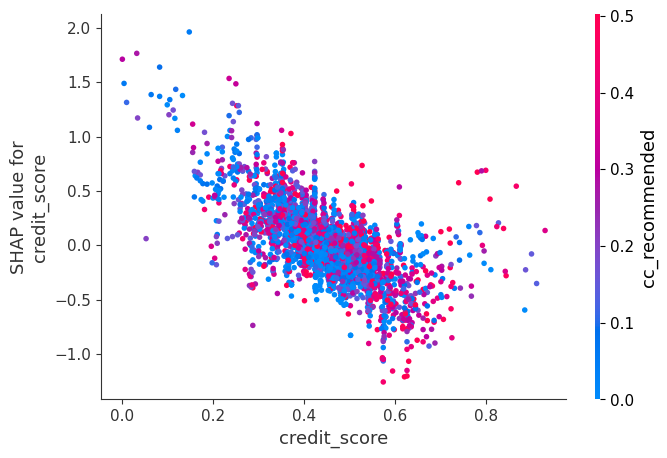

In [ ]:
shap.dependence_plot("credit_score", shap_values_XGB, X_test, interaction_index="cc_recommended")

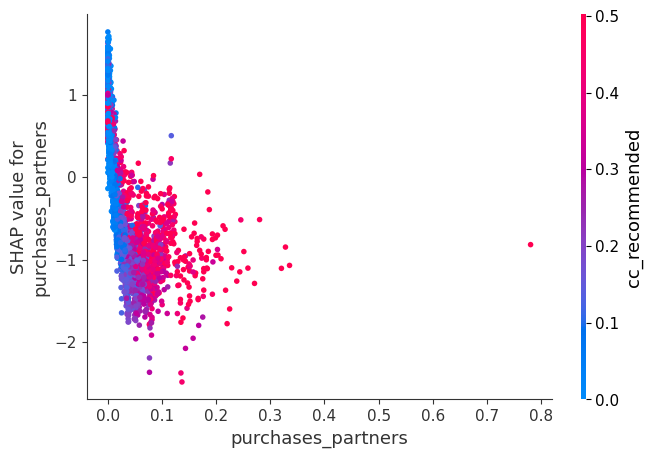

In [ ]:
shap.dependence_plot("purchases_partners", shap_values_XGB, X_test)

### Guardamos los modelos

In [ ]:
# Guardar el modelo
def save_model_and_metadata(model, feature_columns, scaler, feature_importances, explainer, filename):
    """Save the trained model and preprocessing metadata"""
    # Save the model
    joblib.dump(model, filename+'.pkl')
    # Save the scaler
    joblib.dump(scaler, filename+'_scaler.pkl')
    # Save the explainer
    joblib.dump(explainer, filename+'_explainer.pkl')


    # Save feature columns and feature scaler
    metadata = {
        'feature_columns': feature_columns,

    }

    with open(filename+'_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)

    print("Modelo y metadatos guardados!")


In [ ]:
save_model_and_metadata(XGBmodel, XGBcolumns, scaler, XGBfeature_importances,explainerXGB, 'XGBoost_model')
save_model_and_metadata(RFmodel, RFcolumns, scaler, RFfeature_importances,explainerRF,'RandomForest_model')



Modelo y metadatos guardados!
Modelo y metadatos guardados!


In [ ]:
# # Save the explainer
# with open('shap_explainer.pkl', 'wb') as f:
#     pickle.dump(explainer, f)

# Load the explainer for inference
# with open('shap_explainer.pkl', 'rb') as f:
#     loaded_explainer = pickle.load(f)

# # Use the loaded explainer for new predictions
# new_data = X[:5]
# shap_values = loaded_explainer.shap_values(new_data)
# print(shap_values)

In [ ]:
from sklearn.model_selection import learning_curve

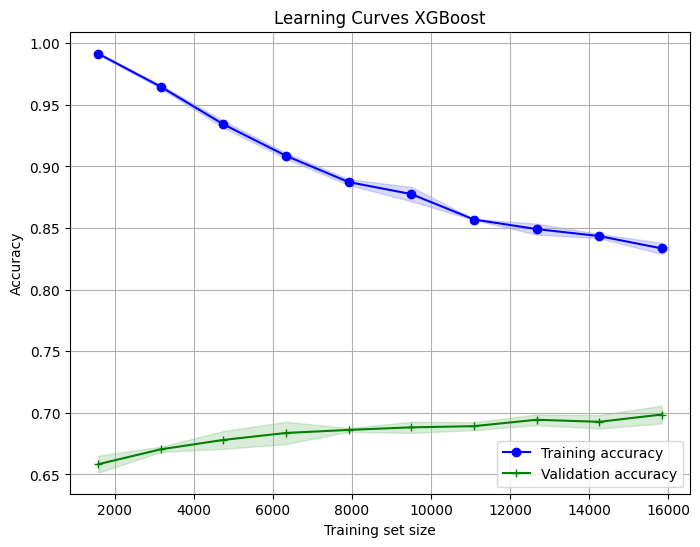

In [ ]:
# Calculate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    estimator=XGBmodel, X=X, y=y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation of scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curves XGBoost')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

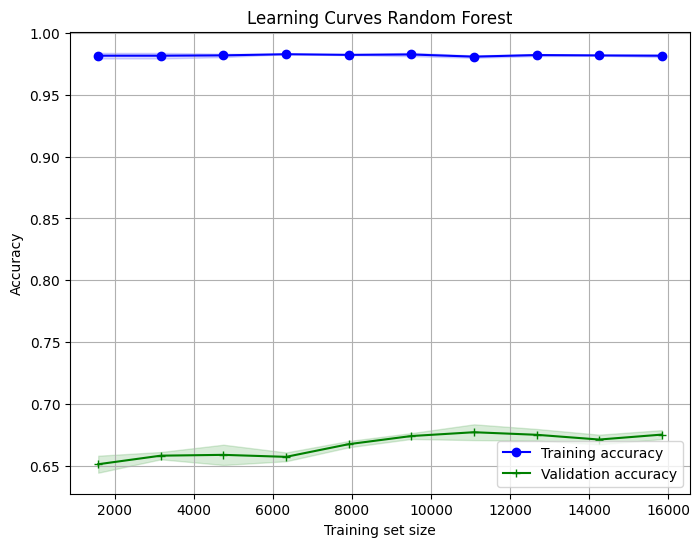

In [ ]:
# Calculate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    estimator=RFmodel, X=X, y=y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation of scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curves Random Forest')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

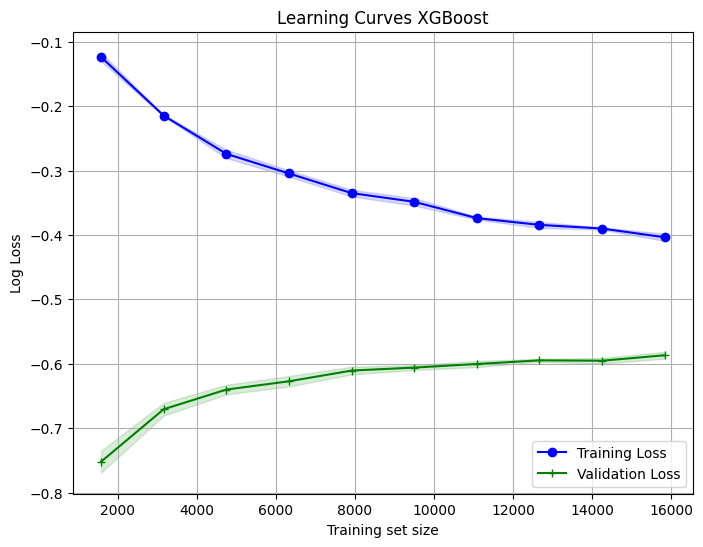

In [ ]:
# Calculate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    estimator=XGBmodel, X=X, y=y, cv=5, scoring='neg_log_loss',
    train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation of scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', label='Training Loss')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', label='Validation Loss')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curves XGBoost')
plt.xlabel('Training set size')
plt.ylabel('Neg Log Loss')
plt.grid()
plt.legend(loc='lower right')
plt.show()

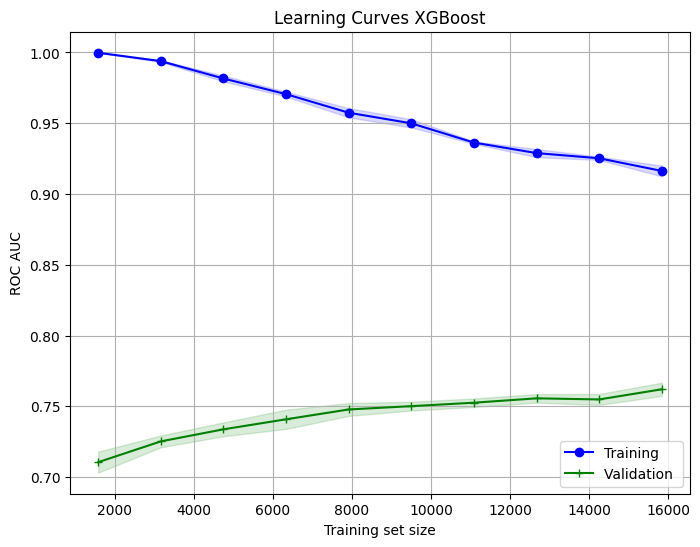

In [ ]:
# Calculate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    estimator=XGBmodel, X=X, y=y, cv=5, scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation of scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', label='Training ')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', label='Validation ')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curves XGBoost')
plt.xlabel('Training set size')
plt.ylabel('ROC AUC')
plt.grid()
plt.legend(loc='lower right')
plt.show()